<a href="https://colab.research.google.com/github/ximeeb/ebertz-gross-lopez-tp-lcs/blob/master/malignant_vs_benign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [2]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from pandas.io.formats.info import DataFrameTableBuilder
import opendatasets as od
import pandas
import cv2
import os
import matplotlib.pyplot as plt
import json
from PIL import Image

In [ ]:
od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

In [8]:
def cargar_imagenes(ruta_carpeta, etiqueta):
    archivos_img = os.listdir(ruta_carpeta)

    imagenes = []
    etiquetas = []
    tamano_img = 100

    for archivo_img in archivos_img:
        if es_imagen(archivo_img):
            ruta_imagen = os.path.join(ruta_carpeta, archivo_img)

            imagen = leer_imagen(ruta_imagen, tamano_img)

            imagenes.append(imagen)
            etiquetas.append(etiqueta)

    return imagenes, etiquetas

In [9]:
def es_imagen(archivo):
  return archivo.endswith('.jpg') or archivo.endswith('.png')

In [10]:
def leer_imagen(ruta, tamano):
  imagen = cv2.imread(ruta, cv2.COLOR_BGR2RGB)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagen = np.array(cv2.resize(imagen, (tamano, tamano)))

  return imagen

In [11]:
import random
def mezclar_con_correspondencia(imagenes, etiquetas):
  combinados = list(zip(imagenes, etiquetas))
  random.shuffle(combinados)
  i, e = zip(*combinados)
  return i, e

In [12]:
# Preparación de imágenes y etiquetas de entrenamiento

ruta_benign = "/content/skin-cancer-malignant-vs-benign/train/benign"
ruta_malignant = "/content/skin-cancer-malignant-vs-benign/train/malignant"

imagenes_benign, etiquetas_benign = cargar_imagenes(ruta_benign, 0)
imagenes_malignant, etiquetas_malignant = cargar_imagenes(ruta_malignant, 1)

imagenes_entrenamiento = imagenes_benign + imagenes_malignant
etiquetas_entrenamiento = etiquetas_benign + etiquetas_malignant

imagenes_entrenamiento, etiquetas_entrenamiento = mezclar_con_correspondencia(imagenes_entrenamiento, etiquetas_entrenamiento)

In [14]:
# Preparación de imágenes y etiquetas de prueba

ruta_benign = "/content/skin-cancer-malignant-vs-benign/test/benign"
ruta_malignant = "/content/skin-cancer-malignant-vs-benign/test/malignant"

imagenes_benign_prueba, etiquetas_benign_prueba = cargar_imagenes(ruta_benign, 0)
imagenes_malignant_prueba, etiquetas_malignant_prueba = cargar_imagenes(ruta_malignant, 1)

imagenes_prueba = imagenes_benign_prueba + imagenes_malignant_prueba
etiquetas_prueba = etiquetas_benign_prueba + etiquetas_malignant_prueba

imagenes_prueba, etiquetas_prueba = mezclar_con_correspondencia(imagenes_prueba, etiquetas_prueba)

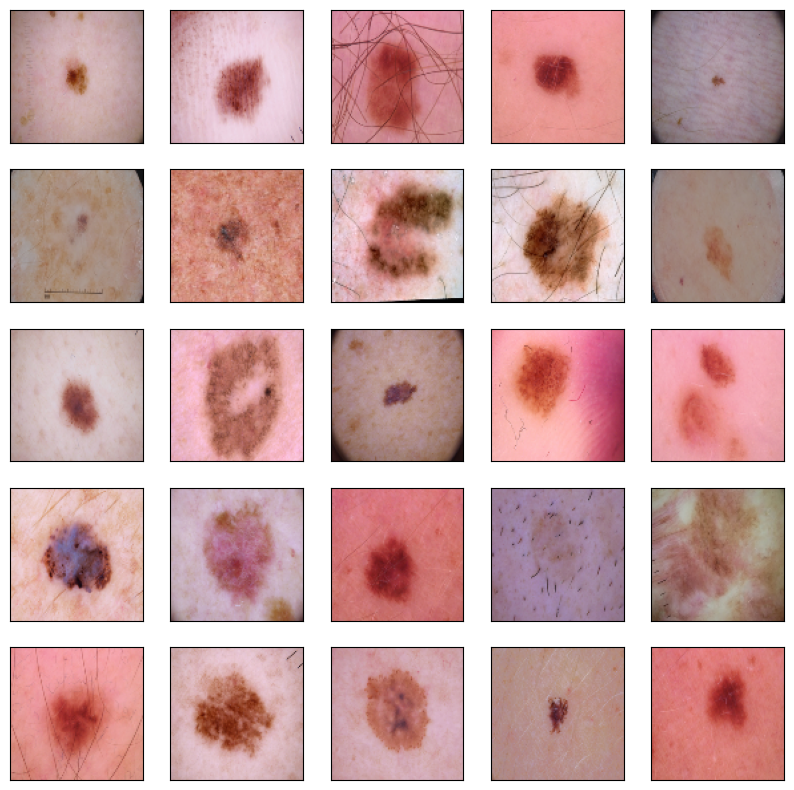

In [19]:
# Mostrar algunas imágenes

plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [20]:
# Normalización de entradas y convirtiendo listas a tensores

imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [107]:
# Preparación de generador de datos

datagen = ImageDataGenerator(
    rotation_range = 50, # Rotación aleatoria de las imágenes
    width_shift_range = 0.1, # Movimiento hacia los lados
    height_shift_range = 0.1, # Movimiento hacia arriba o abajo
    shear_range = 15, # Inclinación
    zoom_range = [0.9, 1.0],
    horizontal_flip = True,
    vertical_flip = True
)

datagen.fit(imagenes_entrenamiento)

In [53]:
modelo_denso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (100, 100, 3)),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

#Compilación
modelo_denso.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
modelo_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#Compilación
modelo_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [103]:
modelo_cnn_ad = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#Compilación
modelo_cnn_ad.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

data_gen_entrenamiento = datagen.flow(imagenes_entrenamiento, etiquetas_entrenamiento, batch_size = 32)

In [110]:
epocas = 20

In [111]:
print("Entrenando modelo denso...")
historial = modelo_denso.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=epocas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)

print("Modelo denso entrenado!")

Entrenando modelo denso...
Epoch 1/20
83/83 [==============================] - 3s 35ms/step - loss: 0.5017 - accuracy: 0.7600 - val_loss: 0.4541 - val_accuracy: 0.7561
Epoch 2/20
83/83 [==============================] - 3s 34ms/step - loss: 0.4907 - accuracy: 0.7539 - val_loss: 0.4378 - val_accuracy: 0.7697
Epoch 3/20
83/83 [==============================] - 3s 33ms/step - loss: 0.4616 - accuracy: 0.7747 - val_loss: 0.4332 - val_accuracy: 0.7621
Epoch 4/20
83/83 [==============================] - 3s 42ms/step - loss: 0.4738 - accuracy: 0.7691 - val_loss: 0.4486 - val_accuracy: 0.7833
Epoch 5/20
83/83 [==============================] - 3s 34ms/step - loss: 0.4539 - accuracy: 0.7736 - val_loss: 0.4416 - val_accuracy: 0.7742
Epoch 6/20
83/83 [==============================] - 3s 34ms/step - loss: 0.4384 - accuracy: 0.7823 - val_loss: 0.4100 - val_accuracy: 0.7833
Epoch 7/20
83/83 [==============================] - 3s 34ms/step - loss: 0.4334 - accuracy: 0.7869 - val_loss: 0.4395 - val_acc

In [113]:
print("Entrenando modelo convolucional...")
historial = modelo_cnn.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=epocas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)

print("Modelo convolucional entrenado!")

Entrenando modelo convolucional...
Epoch 1/20
83/83 [==============================] - 12s 145ms/step - loss: 0.2880 - accuracy: 0.8703 - val_loss: 0.3474 - val_accuracy: 0.8333
Epoch 2/20
83/83 [==============================] - 12s 145ms/step - loss: 0.2360 - accuracy: 0.9006 - val_loss: 0.3651 - val_accuracy: 0.8242
Epoch 3/20
83/83 [==============================] - 12s 145ms/step - loss: 0.2294 - accuracy: 0.8957 - val_loss: 0.3702 - val_accuracy: 0.8424
Epoch 4/20
83/83 [==============================] - 12s 145ms/step - loss: 0.2213 - accuracy: 0.8969 - val_loss: 0.3999 - val_accuracy: 0.8106
Epoch 5/20
83/83 [==============================] - 12s 145ms/step - loss: 0.2410 - accuracy: 0.9014 - val_loss: 0.4407 - val_accuracy: 0.8076
Epoch 6/20
83/83 [==============================] - 15s 177ms/step - loss: 0.1836 - accuracy: 0.9261 - val_loss: 0.4030 - val_accuracy: 0.8273
Epoch 7/20
83/83 [==============================] - 14s 162ms/step - loss: 0.1698 - accuracy: 0.9272 - val_

In [115]:
print("Entrenando modelo convolucional con aumento de datos...")
historial = modelo_cnn_ad.fit(
    data_gen_entrenamiento,
    epochs=epocas,
    batch_size=32,
    validation_data=(imagenes_prueba, etiquetas_prueba),
    steps_per_epoch=int(np.ceil(len(imagenes_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(imagenes_prueba) / float(32)))
)

print("Modelo convolucional entrenado!")

Entrenando modelo convolucional con aumento de datos...
Epoch 1/20
83/83 [==============================] - 16s 192ms/step - loss: 0.3379 - accuracy: 0.8407 - val_loss: 0.3371 - val_accuracy: 0.8121
Epoch 2/20
83/83 [==============================] - 15s 184ms/step - loss: 0.3515 - accuracy: 0.8263 - val_loss: 0.3514 - val_accuracy: 0.8136
Epoch 3/20
83/83 [==============================] - 16s 192ms/step - loss: 0.3551 - accuracy: 0.8278 - val_loss: 0.3341 - val_accuracy: 0.8242
Epoch 4/20
83/83 [==============================] - 15s 185ms/step - loss: 0.3459 - accuracy: 0.8316 - val_loss: 0.3305 - val_accuracy: 0.8212
Epoch 5/20
83/83 [==============================] - 17s 207ms/step - loss: 0.3358 - accuracy: 0.8328 - val_loss: 0.3064 - val_accuracy: 0.8530
Epoch 6/20
83/83 [==============================] - 16s 186ms/step - loss: 0.3261 - accuracy: 0.8369 - val_loss: 0.3203 - val_accuracy: 0.8576
Epoch 7/20
83/83 [==============================] - 16s 191ms/step - loss: 0.3479 - ac

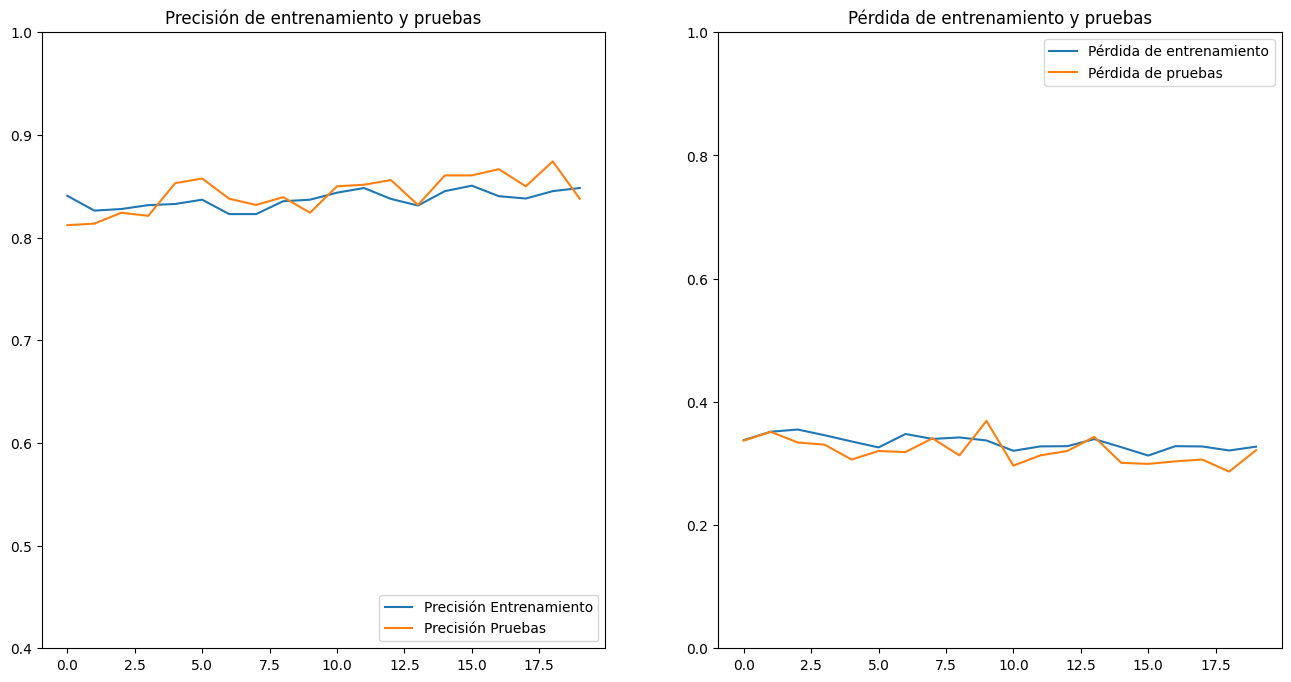

In [116]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(epocas)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.4, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [117]:
import math
def prediccion_es_correcta(esperado, prediccion):
    return round(prediccion[0]) == esperado

In [142]:
def imprimir_testing(predicciones, etiquetas_esperadas, cant_imagenes):
    correctas_tipo = [0, 0]
    falladas_tipo = [0, 0]

    print("Predicciones:", len(predicciones))

    for i in range(cant_imagenes):
      prediccion = predicciones[i]
      esperado = etiquetas_esperadas[i]

      if prediccion_es_correcta(esperado, prediccion):
        correctas_tipo[esperado] += 1
      else:
        falladas_tipo[esperado] += 1

    print("Tipo 0:", correctas_tipo[0], "correctas,", falladas_tipo[0], "incorrectas")
    print("Tipo 1:", correctas_tipo[1], "correctas,", falladas_tipo[1], "incorrectas")

    total_correctas = correctas_tipo[0] + correctas_tipo[1]
    print("Total:", total_correctas, "correctas,", cant_imagenes - total_correctas, "incorrectas\n")

In [143]:
# Testing

imagenes = np.array(imagenes_prueba)

print("Predicciones del modelo denso")
imprimir_testing(modelo_denso.predict(imagenes), etiquetas_prueba, len(imagenes))

print("Predicciones del modelo convolutivo")
imprimir_testing(modelo_cnn.predict(imagenes), etiquetas_prueba, len(imagenes))

print("Predicciones del modelo convolutivo con aumento de datos")
imprimir_testing(modelo_cnn_ad.predict(imagenes), etiquetas_prueba, len(imagenes))

Predicciones del modelo denso
21/21 [==============================] - 0s 10ms/step
Predicciones: 660
Tipo 0: 304 correctas, 56 incorrectas
Tipo 1: 210 correctas, 90 incorrectas
Total: 514 correctas, 146 incorrectas

Predicciones del modelo convolutivo
21/21 [==============================] - 1s 67ms/step
Predicciones: 660
Tipo 0: 278 correctas, 82 incorrectas
Tipo 1: 277 correctas, 23 incorrectas
Total: 555 correctas, 105 incorrectas

Predicciones del modelo convolutivo con aumento de datos
21/21 [==============================] - 1s 43ms/step
Predicciones: 660
Tipo 0: 287 correctas, 73 incorrectas
Tipo 1: 266 correctas, 34 incorrectas
Total: 553 correctas, 107 incorrectas

